## Load DataFrame from GCS

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from snakeclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/16 17:49:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/16 17:49:39 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [7]:
# Get list of stored filed in cloud bucket
! gcloud storage ls gs://dsgt-clef-snakeclef-2024/data/parquet_files/

gs://dsgt-clef-snakeclef-2024/data/parquet_files/

gs://dsgt-clef-snakeclef-2024/data/parquet_files/:
gs://dsgt-clef-snakeclef-2024/data/parquet_files/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/DINOv2-embeddings-large_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/DINOv2-embeddings-medium_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/DINOv2-embeddings-small_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-large_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-medium_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-small_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/


In [8]:
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    BinaryType,
    IntegerType,
    BooleanType,
)
from collections import defaultdict

# Define the schema based on the provided structure
schema = StructType(
    [
        StructField("image_path", StringType(), True),
        StructField("path", StringType(), True),
        StructField("folder_name", StringType(), False),
        StructField("year", StringType(), True),
        StructField("binomial_name", StringType(), True),
        StructField("file_name", StringType(), True),
        StructField("data", BinaryType(), True),
        StructField("observation_id", IntegerType(), True),
        StructField("endemic", BooleanType(), True),
        StructField("code", StringType(), True),
        StructField("class_id", IntegerType(), True),
        StructField("subset", StringType(), True),
    ]
)

# Define the GCS path to the Parquet file
gcs_parquet_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-small_size"

# Read the Parquet file into a DataFrame
df = spark.read.schema(schema).parquet(gcs_parquet_path)

# Show the data (for example, first few rows)
df.show(n=3)

selected_binomial_names = ["Micrurus_fulvius", "Lampropeltis_triangulum", "Morelia_spilota", "Bitis_gabonica", "Agkistrodon_contortrix", "Agkistrodon_piscivorus"]

#write to gcs
df.write.mode("overwrite").parquet("gs://dsgt-clef-snakeclef-2024/data/parquet_files/")


# # Filter the DataFrame to include only rows with binomial names in the list
df = df.filter(df["binomial_name"].isin(selected_binomial_names))

# Create a defaultdict to store counts for each binomial species name
binomial_counts = defaultdict(int)

# Populate the dictionary with counts
for binomial_name in selected_binomial_names:
    count = df.filter(df["binomial_name"] == binomial_name).count()
    binomial_counts[binomial_name] = count

# Iterate through the DataFrame and delete elements as needed
for binomial_name in selected_binomial_names:
    count = binomial_counts[binomial_name]
    rows_to_delete = df.filter(df["binomial_name"] == binomial_name).limit(count - 1)
    df = df.subtract(rows_to_delete)

# Show the resulting DataFrame
df.show()






+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|          image_path|                path|         folder_name|year|       binomial_name|    file_name|                data|observation_id|endemic|code|class_id|subset|
+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|1993/Phrynonax_po...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1993| Phrynonax_polylepis|102870166.jpg|[FF D8 FF E0 00 1...|      64030606|  false|  EC|    1287| train|
|1995/Acrantophis_...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1995|Acrantophis_dumerili| 99694826.jpg|[FF D8 FF E0 00 1...|      62240606|   true|  MG|      11| train|
|1996/Ficimia_stre...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1996|   Ficimia_streckeri| 29265846.jpg|[FF D8 FF E0 00 1...|       2442697|  false|  

+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+-------+--------+------+
|          image_path|                path|         folder_name|year|       binomial_name|    file_name|                data|observation_id|endemic|   code|class_id|subset|
+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+-------+--------+------+
|2020/Lampropeltis...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|2020|Lampropeltis_tria...| 59706126.jpg|[FF D8 FF E0 00 1...|      37638821|  false|unknown|     881| train|
|2013/Bitis_gaboni...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|2013|      Bitis_gabonica| 67361399.jpg|[FF D8 FF E0 00 1...|      42425305|  false|     BI|     159| train|
|2021/Micrurus_ful...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|2021|    Micrurus_fulvius|151162703.jpg|[FF D8 FF E0 00 1...|      9139

In [9]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param image_data_list: List of binary image data.
    :param binomial_names: List of binomial names corresponding to each image.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    for ax, binary_data, name in zip(axes, image_data_list, binomial_names):
        # Convert binary data to an image and display it
        
         # if count_name < 1:
         #    # Convert binary data to an image and display it
         #    image = Image.open(io.BytesIO(binary_data))
         #    ax.imshow(image)
         #    name = name.replace("_", " ")
         #    ax.set_xlabel(name + ", Count: ")  # Set the binomial name as xlabel
         #    ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
         #    ax.set_xticks([])
         #    ax.set_yticks([])
         # Convert binary data to an image and display it
         image = Image.open(io.BytesIO(binary_data))
         ax.imshow(image)
         count_name =  str(binomial_counts[name])
         name = name.replace("_", " ")
         ax.set_xlabel(name + ", Count: " + count_name)  # Set the binomial name as xlabel
         ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
         ax.set_xticks([])
         ax.set_yticks([])

            # Update the count for the current species
    plt.tight_layout()
    plt.show()

defaultdict(<class 'int'>, {'Micrurus_fulvius': 44, 'Lampropeltis_triangulum': 111, 'Morelia_spilota': 71, 'Bitis_gabonica': 68, 'Agkistrodon_contortrix': 61, 'Agkistrodon_piscivorus': 75})
1


2


3


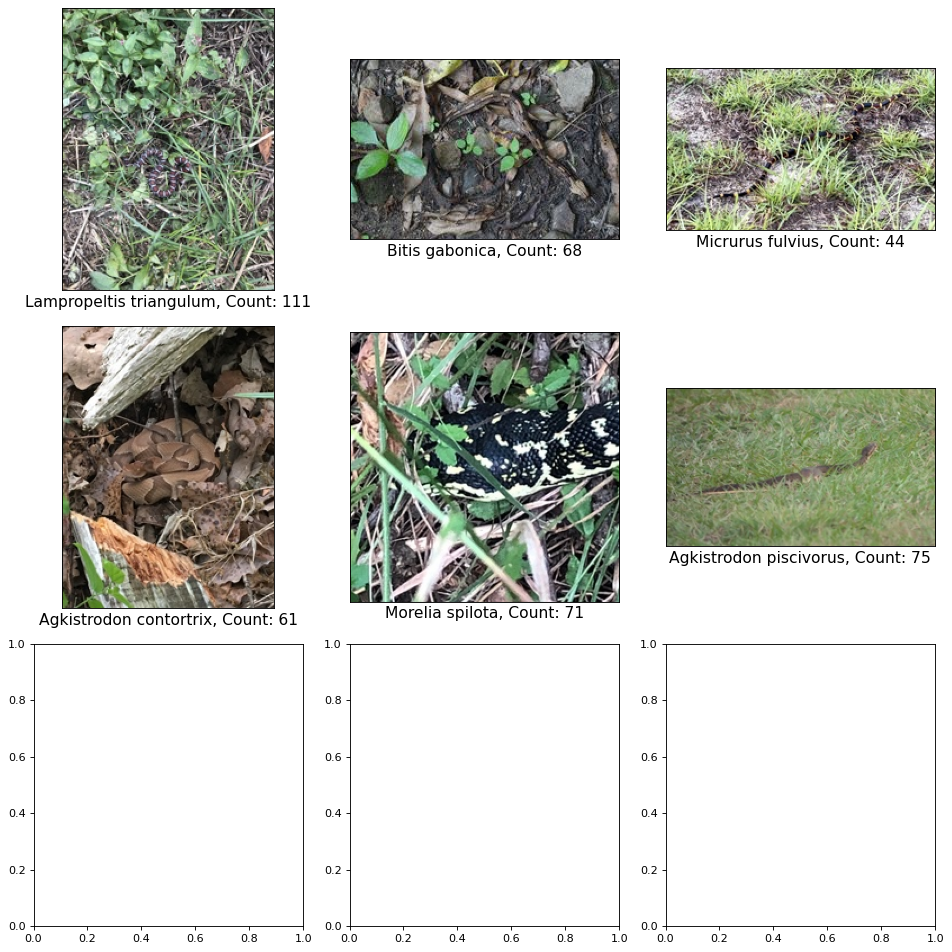

In [10]:
# Collect binary image data from DataFrame
print(binomial_counts)

rows, cols = 3, 2
print("1")

image_data_list = [row["data"] for row in df.limit(rows * cols).collect()]
print("2")
binomial_names = [row["binomial_name"] for row in df.limit(rows * cols).collect()]
print("3")


# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))